In [114]:
import numpy as np
import os
import matplotlib.pyplot as plt
from utils.utils_numpy import nrmse
from utils.utils_vis import title_font_size, axis_font_size, ticks_font_size, width_in_inches, param_names, pk_param_names
from matplotlib.gridspec import GridSpec
import nibabel as nib
# use LaTeX fonts in the plot
from matplotlib.ticker import FormatStrFormatter

In [ ]:
save = False
if save:
    outpath = "output/vis_report_final"
    for subfolder in ["aleatoric", "epistemic", "vivo", "appendix"]:
        if not os.path.exists(f"{outpath}/{subfolder}"):
            os.makedirs(f"{outpath}/{subfolder}")

evaluated_slice = 'slice1'

In [172]:
slice1 = np.load(f'data/vivo/{evaluated_slice}.npz')
data = slice1['data']
mask = slice1['mask']
ct = slice1['ct']
shape = ct.shape

pred_paths = {
    'NLLS' : 'output/vivo/nlls',
    # "SNN": "output/normal/snn_dcenet_1/predictions",
    'PINN' : 'output/vivo/pinn_ph_dcenet_4/predictions',
    # 'PINN (ens)' : 'output/vivo/pinn_ph_dcenet_ens/predictions',
    'MVE' : 'output/normal/mve_snn_dcenet_0/predictions',
    # 'MVE (ens)' : 'output/normal/mve_snn_dcenet_ens/predictions',
}
preds = {name: np.load(os.path.join(path, 'test_slices.npz'), allow_pickle=True)[f'{evaluated_slice}'] for name, path in pred_paths.items()}
preds = {
    name: preds[name].item() for name in pred_paths
}
pred_params = {}
pred_params_full = {}
for name in pred_paths.keys():
    p = preds[name]["pred"]
    if len(p.shape) == 3:
        print(f"{name} reshaping params")
        p = p.reshape(-1, p.shape[-1])
    pred_params[name] = p[:,[0,2,3]].reshape(shape[:2] + (3,))
    pred_params_full[name] = p.reshape(shape[:2] + (4,))

reconstructions = {}
for name in pred_paths.keys():
    rec = preds[name]["reconstruction"]
    if len(rec.shape) == 3:
        print(f"{name} reshaping reconstruction")
        rec = rec.reshape(-1, rec.shape[-1])
    reconstructions[name] = rec.reshape(shape[:2] + (80,))

pred_vars = {}
pred_vars_no_dt = {}
pred_errors = {}
for name in pred_paths.keys()-["SNN"]:
    pred_var = preds[name]["var"].reshape(-1,4)
    pred_vars[name] = pred_var.reshape(shape[:2] + (4,))
    print(pred_var.shape)
    pred_vars_no_dt[name] = pred_var[:,[0,2,3]].reshape(shape[:2] + (3,))
    if len(pred_var.shape) == 3:
        print(f"{name} reshaping variance")
        pred_var = pred_var.reshape(-1, pred_var.shape[-1])
    pred_errors[name] = np.sqrt(pred_var[:,[0,2,3]] * 2 / np.pi).reshape(shape[:2] + (3,))

print()
order = pred_paths.keys()
pred_vars_no_dt = {name: pred_vars_no_dt[name] for name in order}
pred_params = {name: pred_params[name] for name in order}
pred_params_full = {name: pred_params_full[name] for name in order}
pred_errors = {name: pred_errors[name] for name in order}
reconstructions = {name: reconstructions[name] for name in order}


    

(42920, 4)
(42920, 4)
(42920, 4)



(185, 232)
38 99 28 31


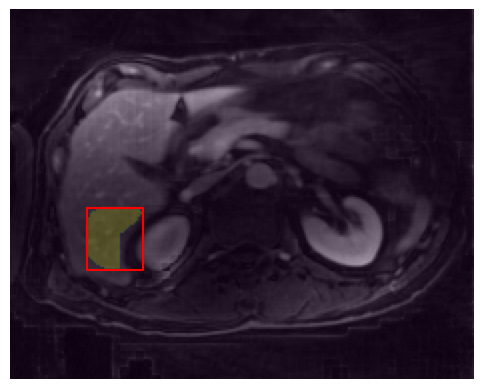

In [173]:
import cv2
mask = nib.load("data/vivo/slice1/LiverPatchMidFilled.nii.gz").get_fdata()[:,:,31].astype(np.uint8)
mask = np.rot90(mask)
mask = np.fliplr(mask)[50:-5,8:]
print(mask.shape)
plt.imshow(data.mean(axis=-1), cmap='gray', vmax=1)
plt.imshow(mask, alpha=0.2)

# find smallest bounding box around mask
mask = mask > 0

mask2 = (mask * 255).astype(np.uint8)
contours, _ = cv2.findContours(mask2, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
contour = contours[0]
x,y,w,h = cv2.boundingRect(contour)
print(x,y,w,h)
plt.plot([x,x+w,x+w,x,x],[y,y,y+h,y+h,y], 'r')
plt.axis('off')
plt.show()
plt.close()



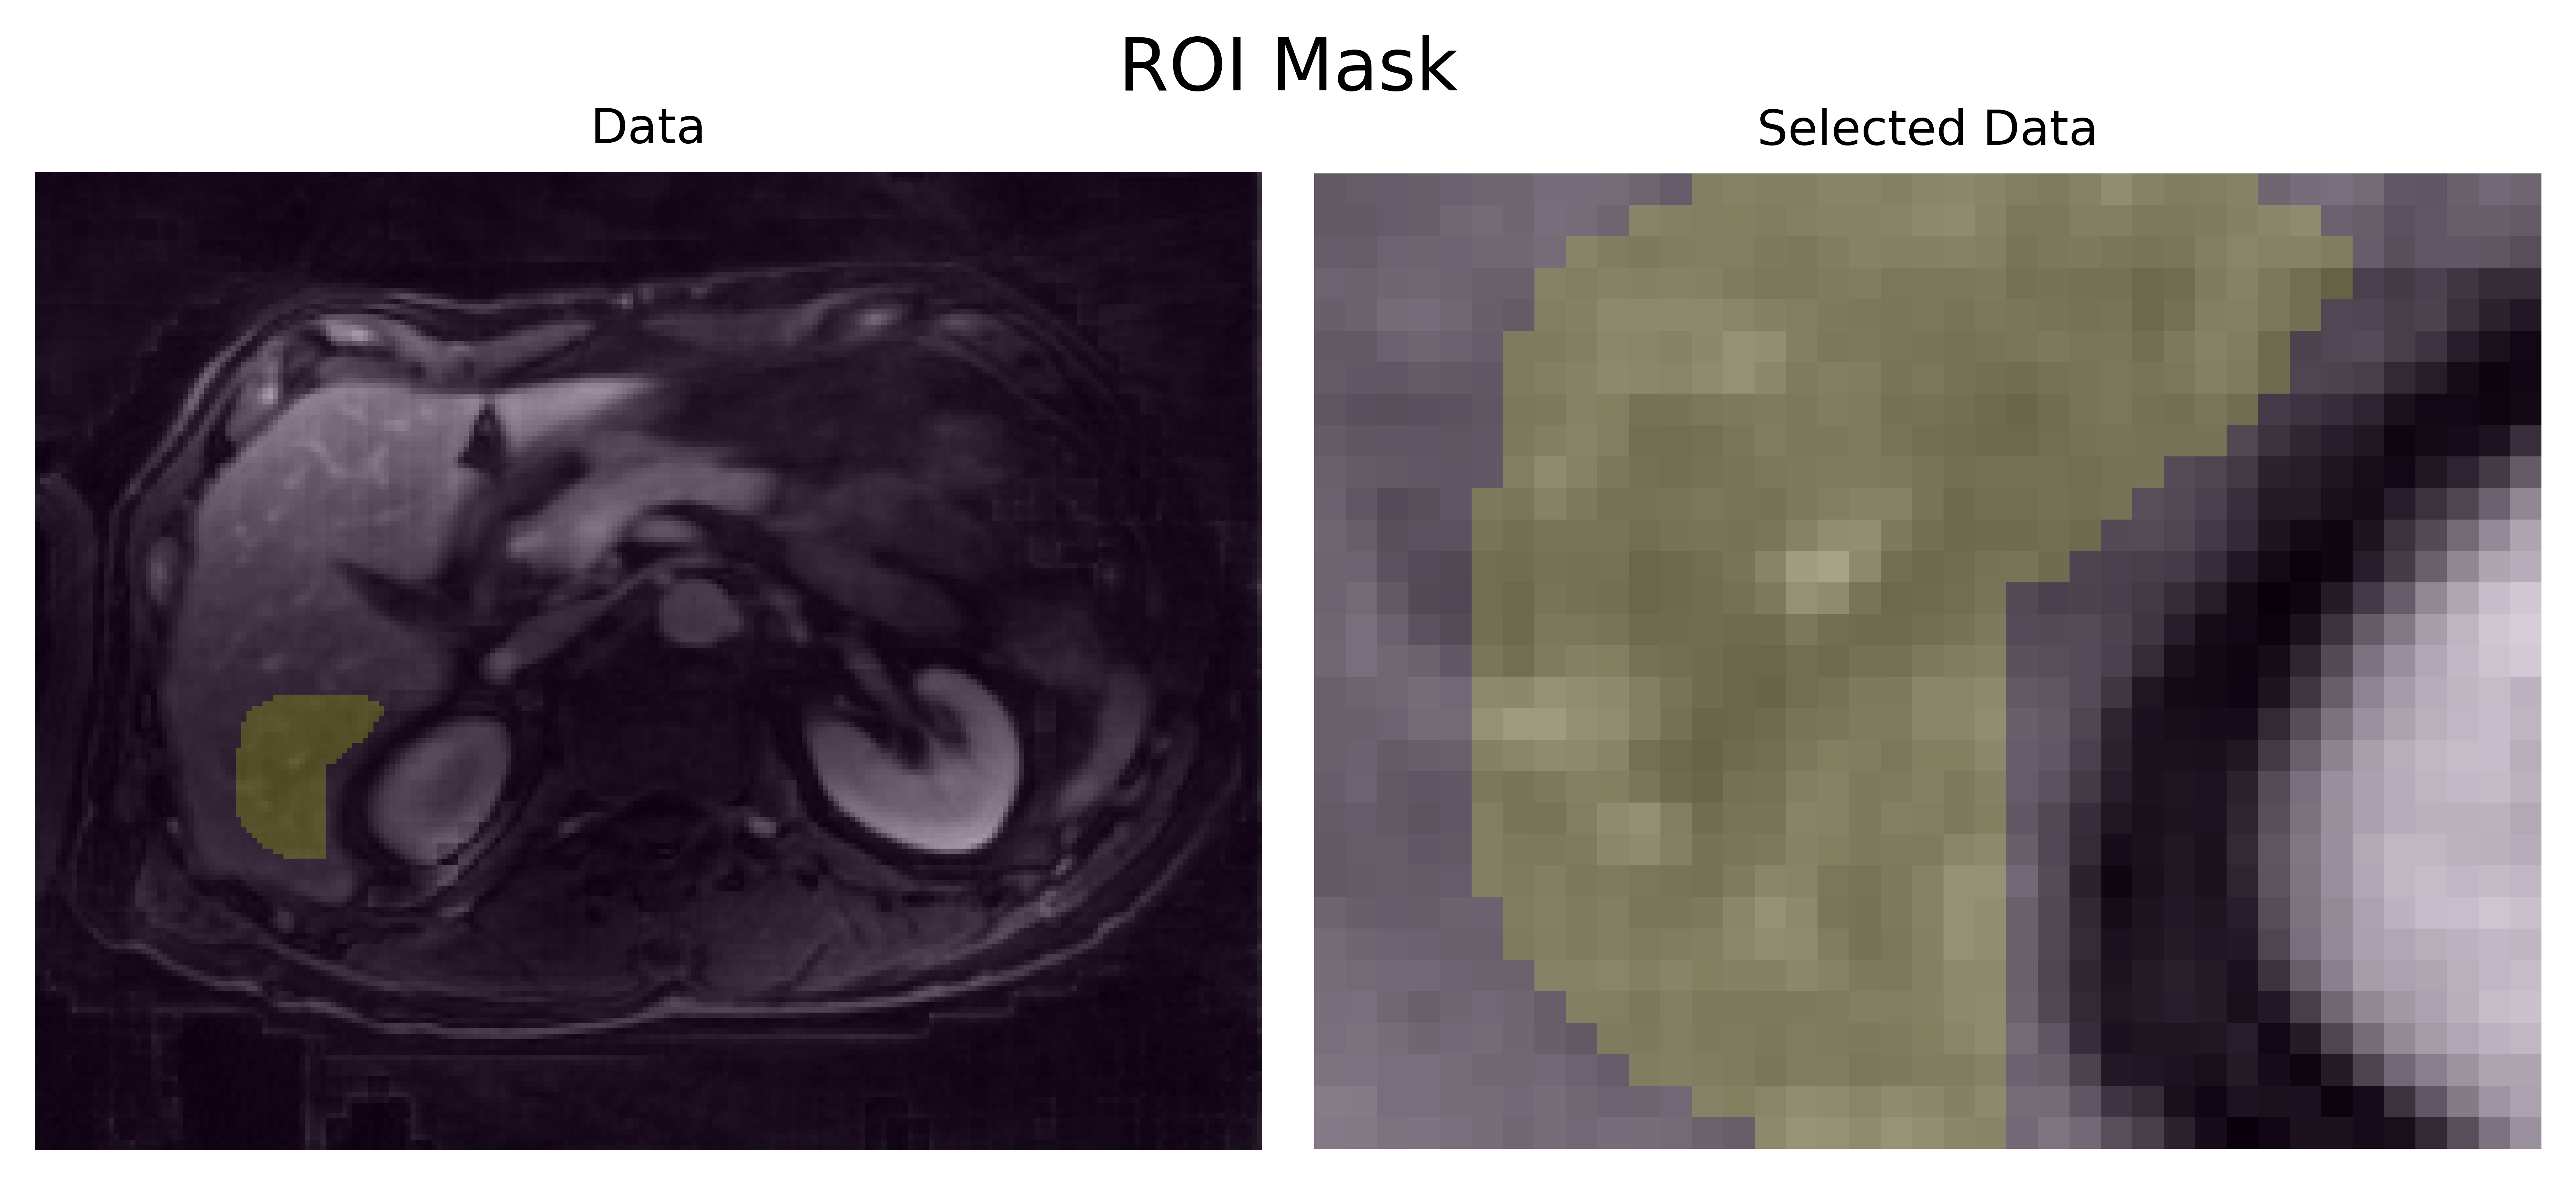

In [174]:
fig, axs = plt.subplots(1,2, figsize=(width_in_inches, width_in_inches/2), dpi=1000)
axs[0].imshow(data.mean(axis=-1), cmap='gray', vmax=1)
axs[0].imshow(mask, alpha=0.2)
axs[0].axis('off')
axs[0].set_title('Data', fontsize=axis_font_size)

axs[1].imshow(data[y:y+h,x-5:x+w+6].mean(axis=-1), cmap='gray', vmax=0.4)
axs[1].imshow(mask[y:y+h,x-5:x+w+6], alpha=0.15)
axs[1].axis('off')
axs[1].set_title('Selected Data', fontsize=axis_font_size)
plt.tight_layout()

plt.suptitle('ROI Mask', fontsize=title_font_size)
if save:
    plt.savefig(f'{outpath}/appendix/ROI_mask.jpg', dpi=1000, bbox_inches='tight', format='jpg')


In [175]:
from collections import defaultdict
average_parameters_mask = {
    name: np.mean(pred_params[name] * mask[...,None].repeat(3,axis=-1), axis=(0,1)) for name in pred_paths.keys()
}

sd_parameters_mask = {
    name: np.std(pred_params[name] * mask[...,None].repeat(3,axis=-1), axis=(0,1)) for name in pred_paths.keys()
}

outlier_cutoff = [3,1,0.05]

parameter_in_mask = defaultdict(lambda: [])
average_parameter_mask = defaultdict(lambda: [])
sd_parameters_mask = defaultdict(lambda: [])
uct_in_mask = defaultdict(lambda: [])
mean_uct_in_mask =defaultdict(lambda: [])
median_uct_in_mask = defaultdict(lambda: [])

for name in pred_paths.keys():
    for j in range(3):
        params = pred_params[name][:,:,j][mask]
        parameter_in_mask[name].append(params)
        average_parameter_mask[name].append(np.mean(params))
        sd_parameters_mask[name].append(np.std(params))
        pred_stds = np.sqrt(pred_vars_no_dt[name][:,:,j][mask])
        # filter outliers
        # pred_stds = pred_stds[pred_stds < outlier_cutoff[j]]
        
        uct_in_mask[name].append(pred_stds)
        mean_uct_in_mask[name].append(np.mean(pred_stds))
        median_uct_in_mask[name].append(np.median(pred_stds))

print(sd_parameters_mask)

defaultdict(<function <lambda> at 0x2a7346660>, {'NLLS': [0.5807991254020136, 0.09772075225405714, 0.009958341674715685], 'PINN': [0.2905585, 0.08917654, 0.004099369], 'MVE': [0.32906052, 0.10204853, 0.012165844]})


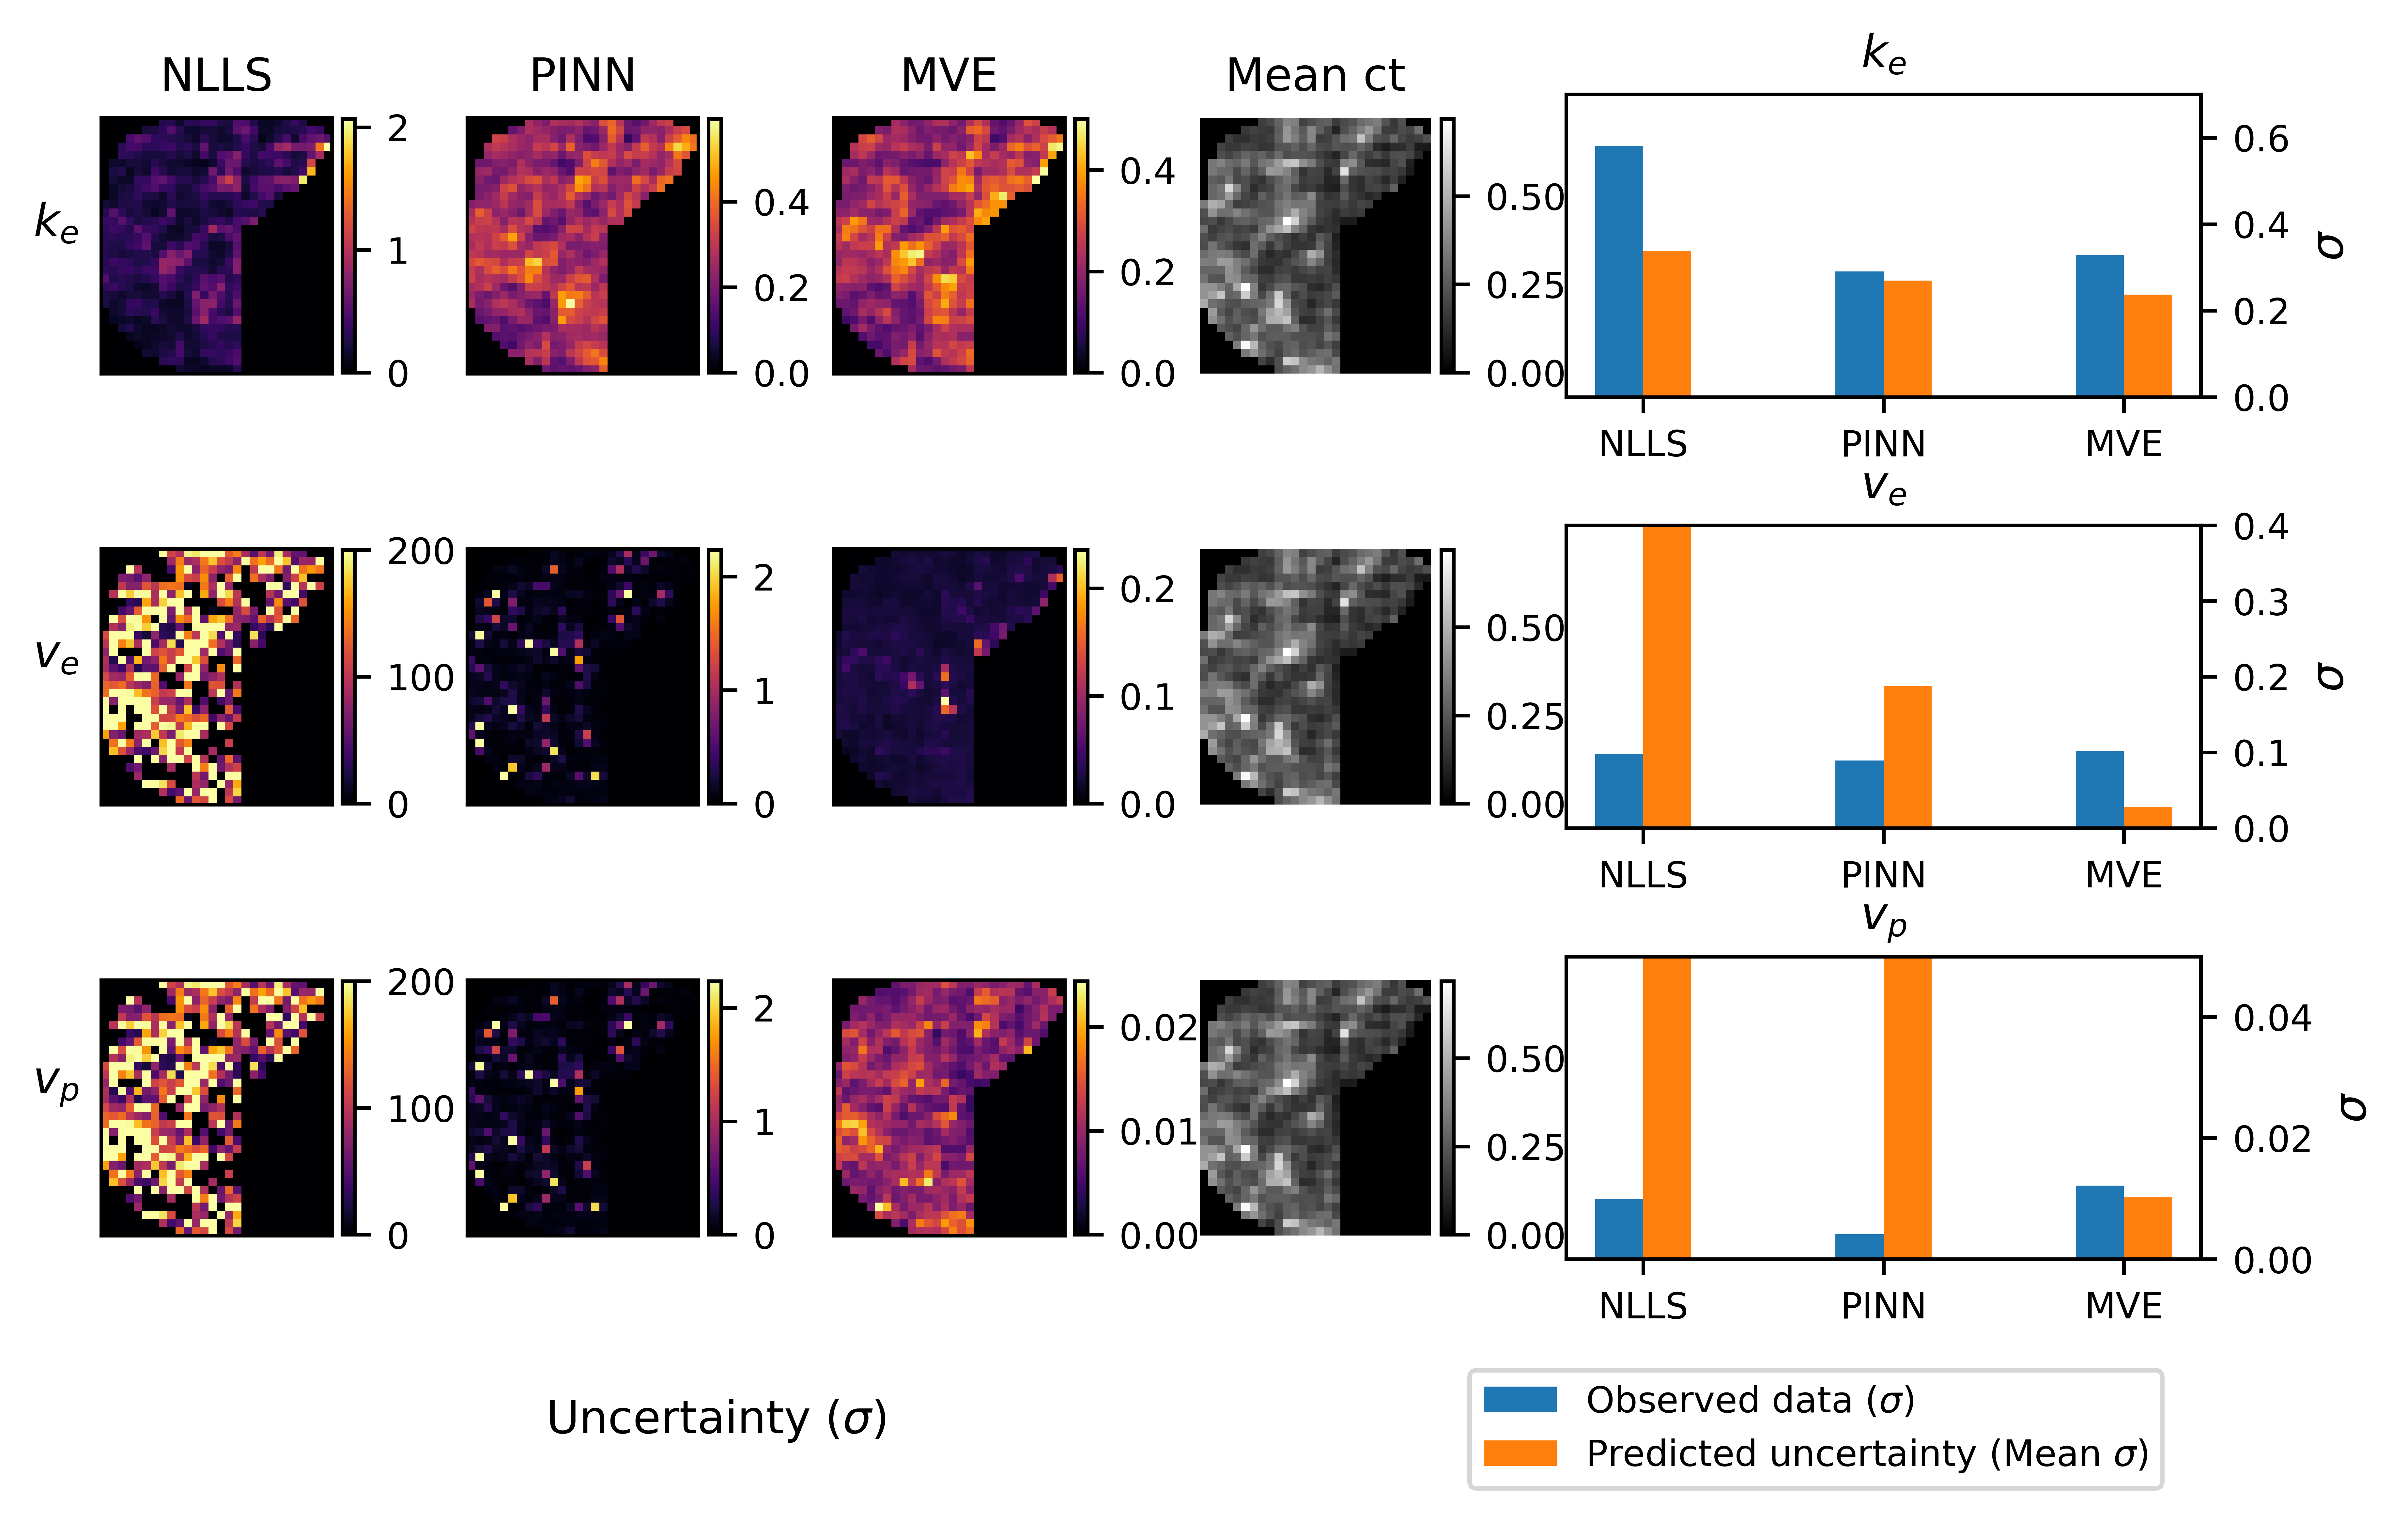

In [176]:
fig = plt.figure(figsize=(width_in_inches, width_in_inches*3/5), dpi=1000)
gs = GridSpec(3, 5, figure=fig, width_ratios=[1, 1, 1, 1, 2.5])
maxes = [0.7, 0.4, 0.05]
xt= np.arange(3)

for i in range(3):
    ax = fig.add_subplot(gs[i,3])
    cbar = plt.colorbar(ax.imshow(ct[y:y+h,x:x+w].mean(axis=-1)*mask[y:y+h,x:x+w], cmap='gray'), ax=ax, fraction=0.05, pad=0.04)
    cbar.ax.tick_params(labelsize=ticks_font_size)
    # ax.imshow(mask[y:y+h,x-5:x+w+6], alpha=0.2)
    ax.axis('off')
    if i ==0:
        ax.set_title('Mean ct', fontsize=axis_font_size)

for i, (name, vars) in enumerate(pred_vars_no_dt.items()):
    sd = np.sqrt(np.maximum(vars, 0))
    for j in range(3):
        ax = fig.add_subplot(gs[j,i])
        vis = sd[:,:,j] * mask
        assert sd[:,:,j].shape == mask.shape
        vis = vis[y:y+h,x:x+w]
        mx = min(vis.max(), 200.0)
        ax.imshow(vis, cmap='inferno', vmax=mx)
        cbar = plt.colorbar(ax.imshow(vis, cmap='inferno', vmax=mx), ax=ax, fraction=0.05, pad=0.04)
        cbar.ax.tick_params(labelsize=ticks_font_size)

        # outliers = vis > outlier_cutoff[j]
        # ax.imshow(outliers, cmap='Blues', alpha=0.5)

        if i == 0:
            ax.set_ylabel(pk_param_names[j], fontsize=axis_font_size, rotation=0, labelpad=10)
        if j == 0:
            ax.set_title(name, fontsize=axis_font_size)
        ax.set_xticks([])
        ax.set_yticks([])

for i, pname in enumerate(pk_param_names):
    ax = fig.add_subplot(gs[i,4])
    observed_sd = [sd_parameters_mask[name][i] for name in sd_parameters_mask.keys()]
    predicted_uct = [mean_uct_in_mask[name][i] for name in uct_in_mask.keys()]

    # Boxplot for observed, median UCT, and mean UCT
    width=0.2
    ax.bar(xt-width/2, observed_sd, width, label='Observed')
    # box = ax.boxplot(predicted_uct, positions=xt+width/2, widths=width, showfliers=False, labels=pk_param_names, patch_artist=True, boxprops=dict(facecolor='lightblue'), medianprops=dict(color='red'))
    ax.bar(xt+width/2, predicted_uct, width, label='mean UCT')


    ax.set_ylabel('$\\sigma$', fontsize=axis_font_size)
    ax.set_title(pname, fontsize=axis_font_size)
    ax.set_ylim([0, maxes[i]])
    # ax.set_yscale('log')
    ax.set_xticks(xt)
    ax.set_xticklabels(sd_parameters_mask.keys())
    ax.tick_params(axis='both', labelsize=ticks_font_size)
    # place y axis on the right
    ax.yaxis.tick_right()
    ax.yaxis.set_label_position("right")


handles = ax.get_legend_handles_labels()[0]
# handles.extend([box['boxes'][0]])
# handles.extend([plt.Line2D([0], [0], color='red', lw=2)])
fig.legend(handles, ['Observed data ($\\sigma$)', 'Predicted uncertainty (Mean $\\sigma$)'], loc='lower right', ncol=1, fontsize=ticks_font_size, bbox_to_anchor=(0.9,-0.04), bbox_transform=fig.transFigure)
# plt.suptitle(f'Observed and predicted SD in liver ROI', fontsize=title_font_size)
fig.text(0.3, 0.01, 'Uncertainty ($\\sigma$)', fontsize=axis_font_size, ha='center')

plt.tight_layout(rect=[0, 0.05, 1, 1], h_pad=0.0, w_pad=0.0)

if save:
    plt.savefig(f'{outpath}/vivo/ROI_overview.jpg', bbox_inches='tight', format='jpg', dpi=1000)

In [180]:
pred_params.keys()

dict_keys(['NLLS', 'PINN', 'MVE'])

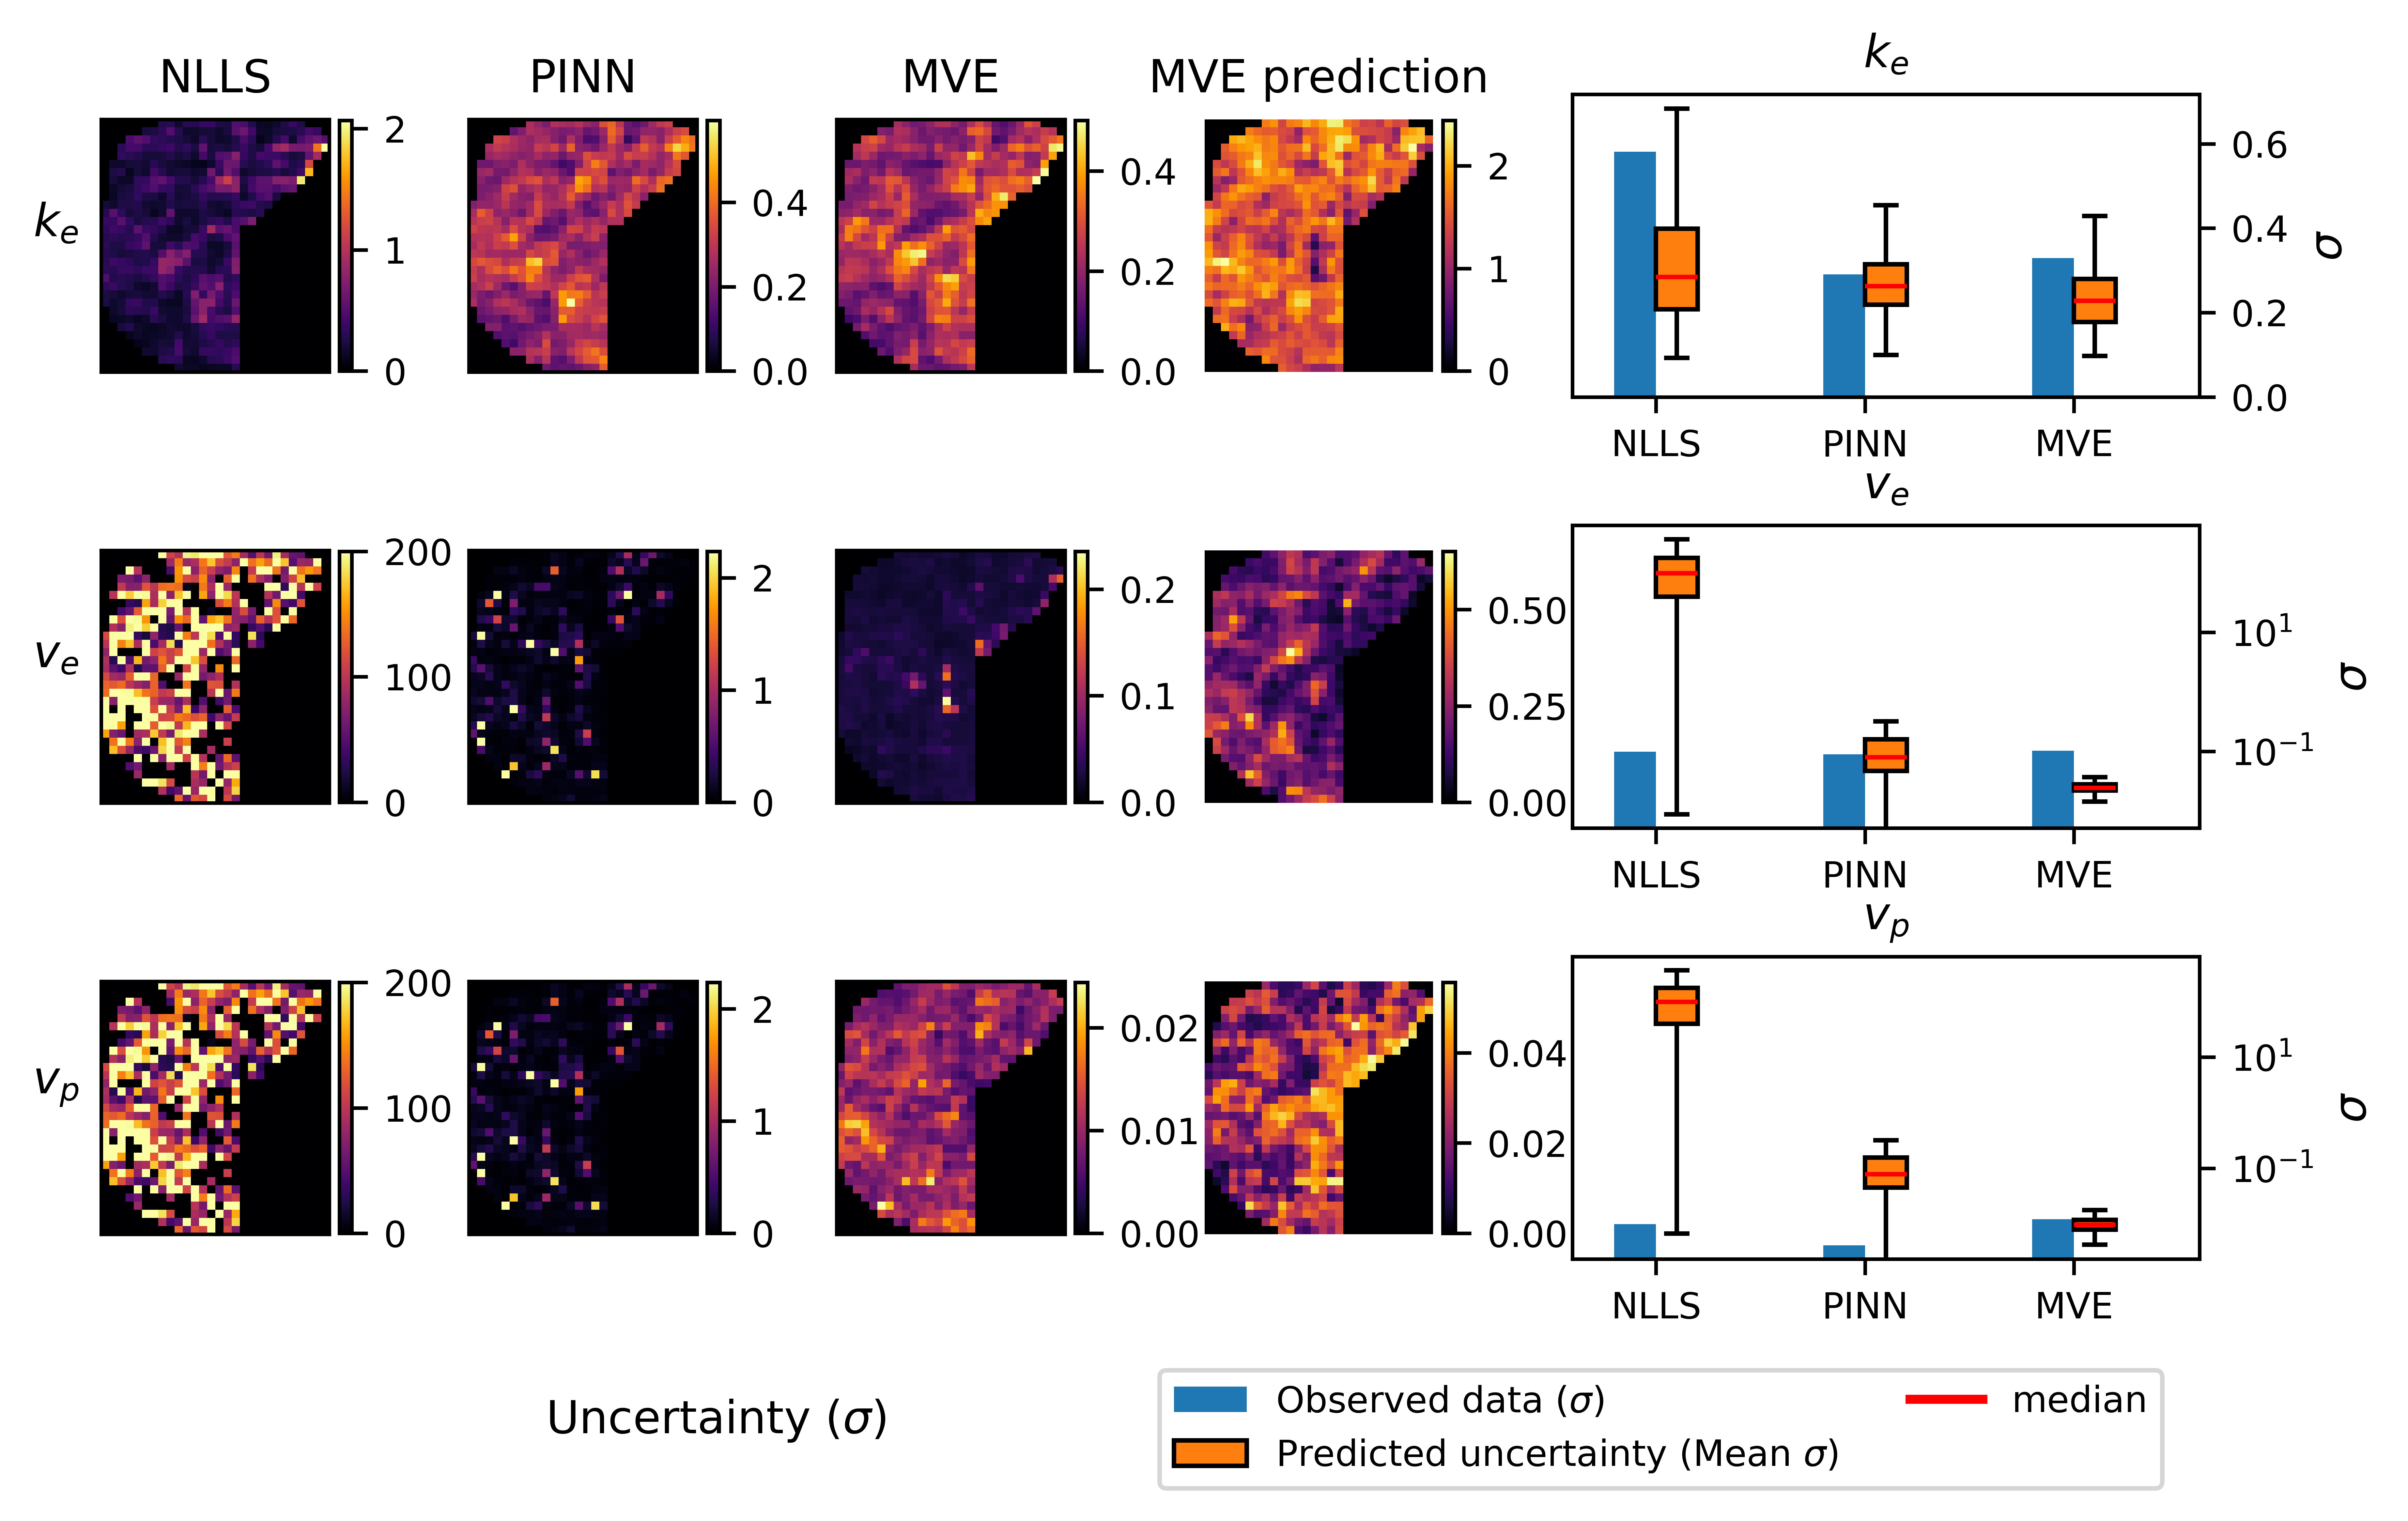

In [183]:
fig = plt.figure(figsize=(width_in_inches, width_in_inches*3/5), dpi=1000)
gs = GridSpec(3, 5, figure=fig, width_ratios=[1, 1, 1,1, 2.5])
maxes = [0.7, 0.4, 0.05]
xt= np.arange(3)

for i in range(3):
    ax = fig.add_subplot(gs[i,3])
    cbar = plt.colorbar(ax.imshow(pred_params['MVE'][y:y+h,x:x+w,i]*mask[y:y+h,x:x+w], cmap='inferno'), ax=ax, fraction=0.05, pad=0.04)
    cbar.ax.tick_params(labelsize=ticks_font_size)
    # ax.imshow(mask[y:y+h,x-5:x+w+6], alpha=0.2)
    ax.axis('off')
    if i ==0:
        ax.set_title('MVE prediction', fontsize=axis_font_size)

for i, (name, vars) in enumerate(pred_vars_no_dt.items()):
    sd = np.sqrt(np.maximum(vars, 0))
    for j in range(3):
        ax = fig.add_subplot(gs[j,i])
        vis = sd[:,:,j] * mask
        vis = vis[y:y+h,x:x+w]
        mx = min(vis.max(), 200.0)
        ax.imshow(vis, cmap='inferno', vmax=mx)
        cbar = plt.colorbar(ax.imshow(vis, cmap='inferno', vmax=mx), ax=ax, fraction=0.05, pad=0.04)
        cbar.ax.tick_params(labelsize=ticks_font_size)
        if i == 0:
            ax.set_ylabel(pk_param_names[j], fontsize=axis_font_size, rotation=0, labelpad=10)
        if j == 0:
            ax.set_title(name, fontsize=axis_font_size)
        ax.set_xticks([])
        ax.set_yticks([])

for i, pname in enumerate(pk_param_names):
    ax = fig.add_subplot(gs[i,4])
    observed_sd = [sd_parameters_mask[name][i] for name in sd_parameters_mask.keys()]
    predicted_uct = [uct_in_mask[name][i] for name in uct_in_mask.keys()]

    # Boxplot for observed, median UCT, and mean UCT
    width=0.2
    ax.bar(xt-width/2, observed_sd, width, label='Observed')
    box = ax.boxplot(predicted_uct, positions=xt+width/2, widths=width, showfliers=False, labels=pk_param_names, patch_artist=True, boxprops=dict(facecolor="tab:orange"), medianprops=dict(color='red'))
    # get the positoin of the boxplot caps
    caps = [item.get_ydata() for item in box['caps']]

    ax.set_ylabel('$\\sigma$', fontsize=axis_font_size)
    ax.set_title(pname, fontsize=axis_font_size)
    # ax.set_ylim([0, maxes[i]])
    if i > 0:
        ax.set_yscale('log')
    ax.set_xticks(xt)
    ax.set_xticklabels(sd_parameters_mask.keys())
    ax.tick_params(axis='both', labelsize=ticks_font_size)
    # place y axis on the right
    ax.yaxis.tick_right()
    ax.yaxis.set_label_position("right")


handles = ax.get_legend_handles_labels()[0]
handles.extend([box['boxes'][0]])
handles.extend([plt.Line2D([0], [0], color='red', lw=2)])

# handles.extend([box['boxes'][0]])
# handles.extend([plt.Line2D([0], [0], color='red', lw=2)])
fig.legend(handles, ['Observed data ($\\sigma$)', 'Predicted uncertainty (Mean $\\sigma$)', 'median'], loc='lower right', ncol=2, fontsize=ticks_font_size, bbox_to_anchor=(0.9,-0.04), bbox_transform=fig.transFigure)
# plt.suptitle(f'Observed and predicted SD in liver ROI', fontsize=title_font_size)
fig.text(0.3, 0.01, 'Uncertainty ($\\sigma$)', fontsize=axis_font_size, ha='center')

plt.tight_layout(rect=[0, 0.05, 1, 1], h_pad=0.0, w_pad=0.1)

if save:
    plt.savefig(f'{outpath}/vivo/ROI_overview_boxes.jpg', bbox_inches='tight', format='jpg', dpi=1000)

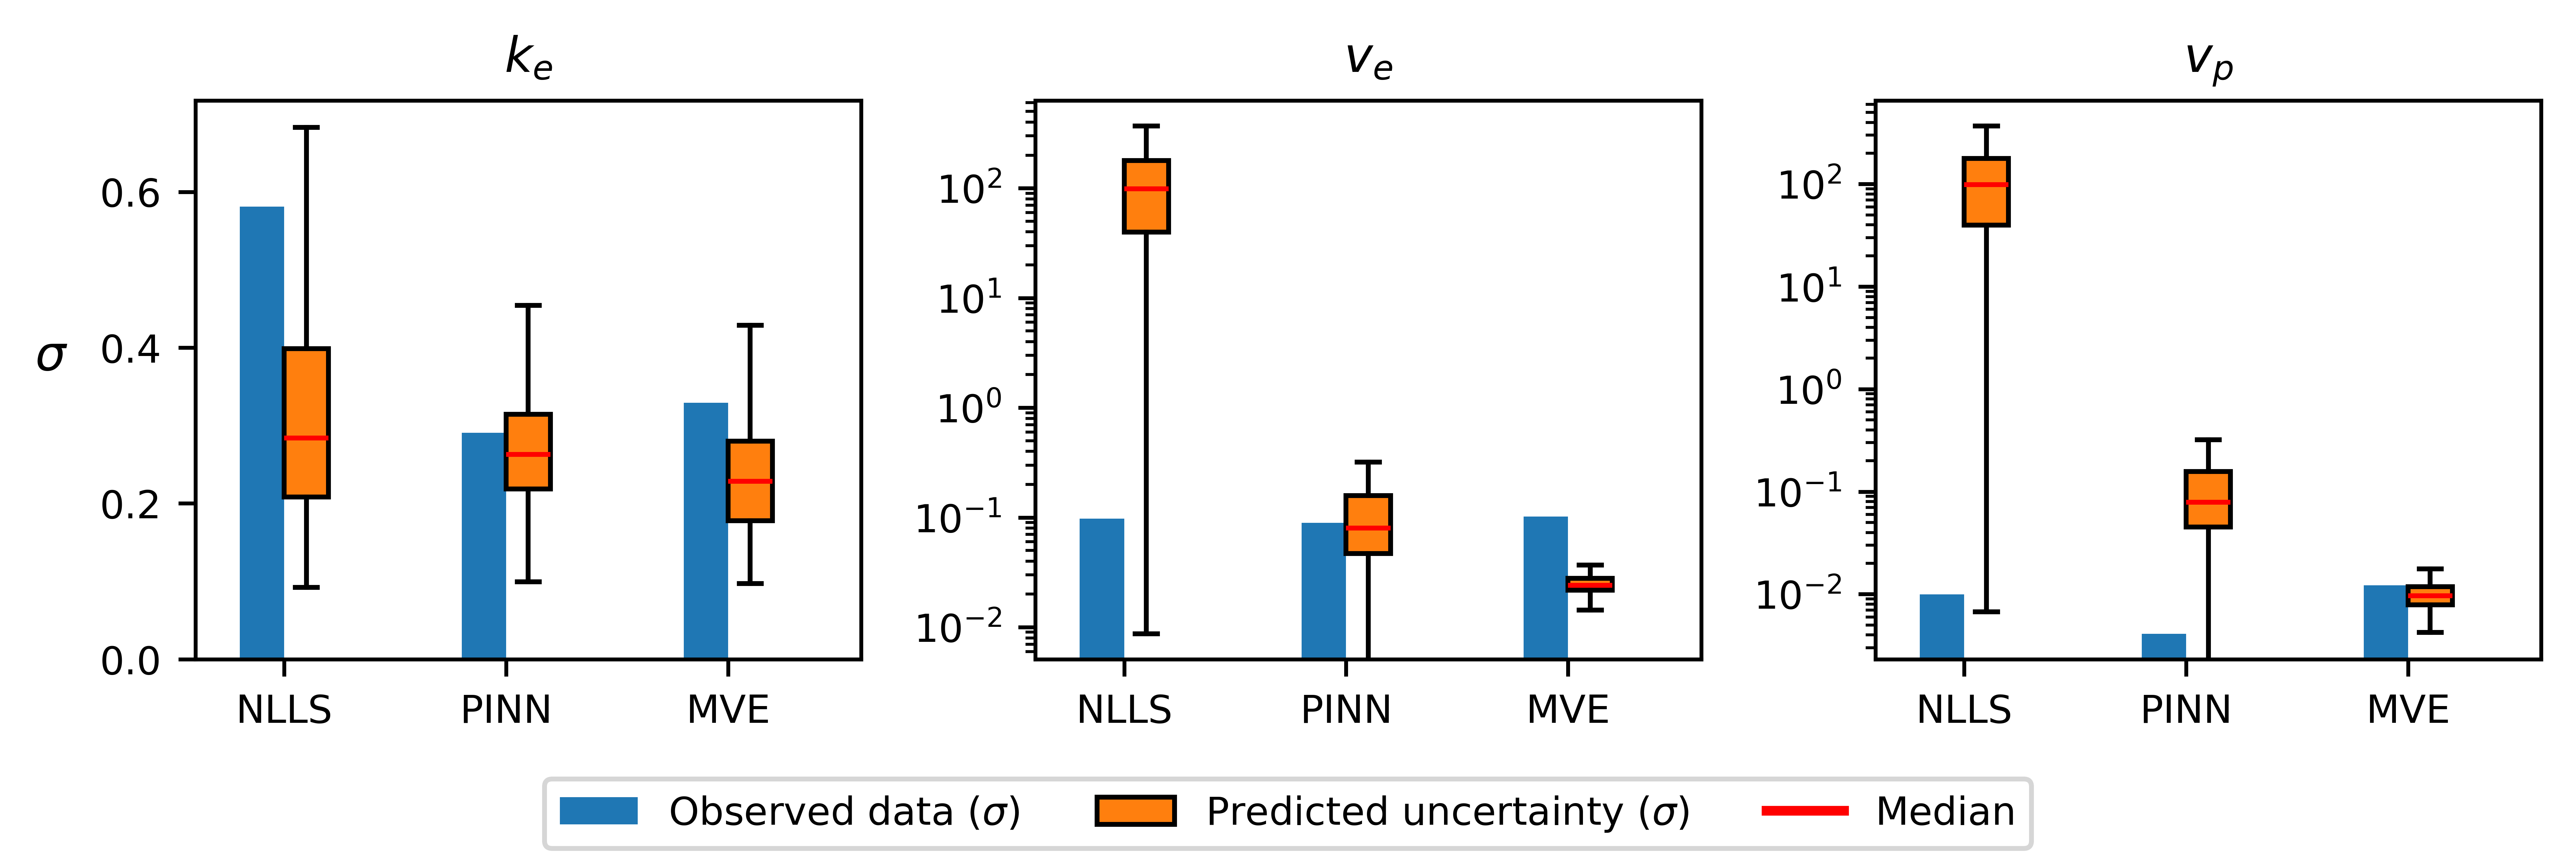

In [11]:
fig = plt.figure(figsize=(width_in_inches, width_in_inches / 3), dpi=1000)
gs = GridSpec(1, 3, figure=fig, width_ratios=[1, 1, 1])

for i, name in enumerate(pk_param_names):
    ax = fig.add_subplot(gs[i])
    observed_sd = [sd_parameters_mask[name][i] for name in sd_parameters_mask.keys()]
    predicted_uct = [uct_in_mask[name][i] for name in uct_in_mask.keys()]

    # Boxplot for observed, median UCT, and mean UCT
    width=0.2
    ax.bar(xt-width/2, observed_sd, width, label='Observed')
    box = ax.boxplot(predicted_uct, positions=xt+width/2, widths=width, showfliers=False, labels=pk_param_names, patch_artist=True, boxprops=dict(facecolor="tab:orange"), medianprops=dict(color='red'))
    # get the positoin of the boxplot caps
    caps = [item.get_ydata() for item in box['caps']]

    if i ==0:
        ax.set_ylabel('$\\sigma$', fontsize=axis_font_size, rotation=0, labelpad=10)
    ax.set_title(name, fontsize=axis_font_size)
    ax.set_xticks(xt)
    ax.set_xticklabels(sd_parameters_mask.keys())
    ax.tick_params(axis='both', labelsize=ticks_font_size)
    if i > 0:
        ax.set_yscale('log')



handles = ax.get_legend_handles_labels()[0]
handles.extend([box['boxes'][0]])
handles.extend([plt.Line2D([0], [0], color='red', lw=2)])
fig.legend(handles, ['Observed data ($\\sigma$)', 'Predicted uncertainty ($\\sigma$)', 'Median'], loc='lower center', ncol=3, fontsize=ticks_font_size)
# plt.suptitle(f'Observed and predicted SD in liver ROI', fontsize=title_font_size)
plt.tight_layout(rect=[0, 0.08, 1, 1])

if save:
    plt.savefig(f'{outpath}/appendix/ROI_full.jpg', bbox_inches='tight', format='jpg', dpi=1000)


## NOTE
code below creates additional plots not used in the report, mostly to visualise the above plot in separate figures.

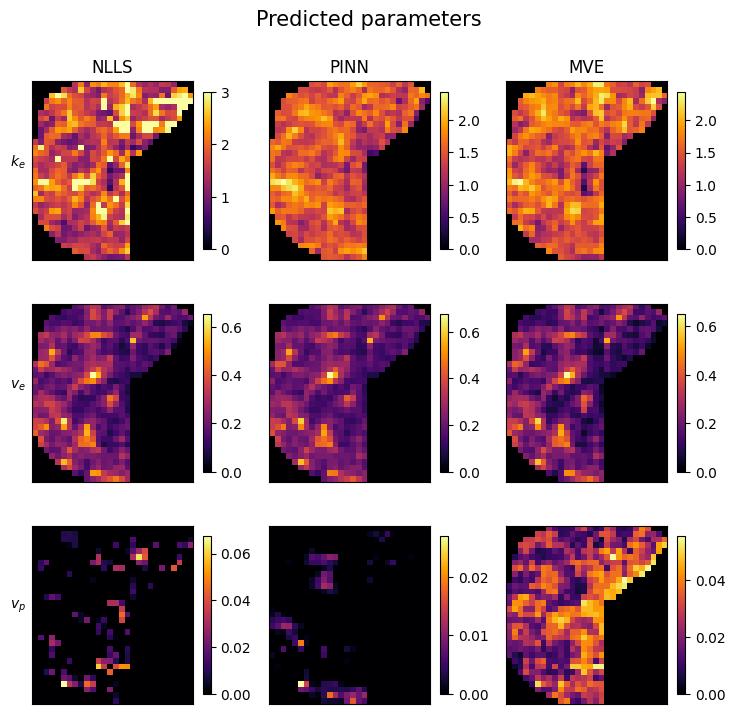

In [9]:
# plot the parameter predictions in the mask
fig = plt.figure(figsize=(width_in_inches, width_in_inches))
gs = GridSpec(3, 3, figure=fig, width_ratios=[1,1,1])
for i, (name, params) in enumerate(pred_params.items()):
    params = np.maximum(params, 0)
    for j in range(3):
        ax = fig.add_subplot(gs[j,i])
        vis = params[:,:,j] * mask
        vis = vis[y:y+h,x:x+w]
        ax.imshow(vis, cmap='gray')
        cbar = plt.colorbar(ax.imshow(vis, cmap='inferno'), ax=ax, shrink=0.7)
        if i == 0:
            ax.set_ylabel(pk_param_names[j], fontsize=axis_font_size, rotation=0, labelpad=10)
        ax.set_xticks([])
        ax.set_yticks([])
        if j == 0:
            ax.set_title(name)
plt.suptitle('Predicted parameters', fontsize=title_font_size)
plt.tight_layout()

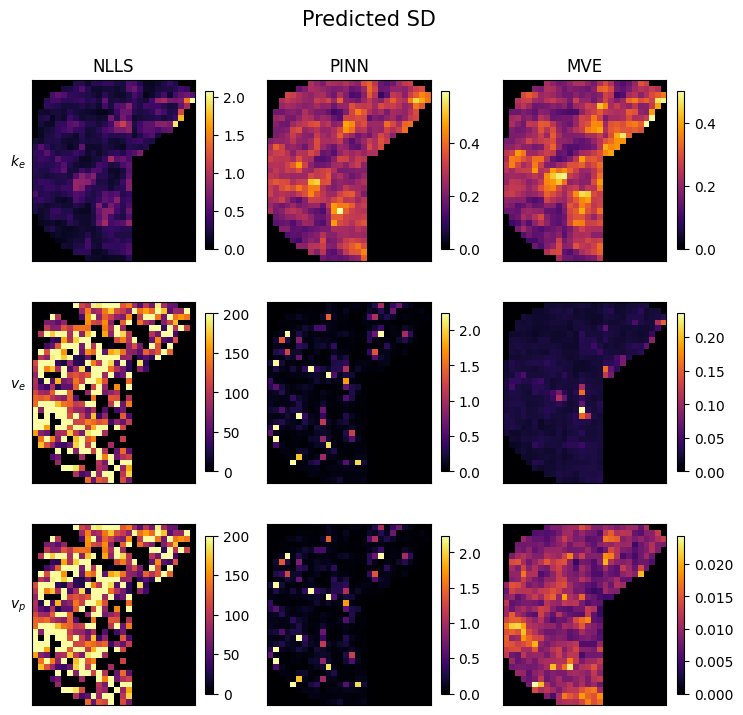

In [10]:
# plot the parameter predictions in the mask
fig = plt.figure(figsize=(width_in_inches, width_in_inches))
gs = GridSpec(3, 3, figure=fig, width_ratios=[1,1,1])
for i, (name, vars) in enumerate(pred_vars_no_dt.items()):
    sd = np.sqrt(np.maximum(vars, 0))
    for j in range(3):
        ax = fig.add_subplot(gs[j,i])
        vis = sd[:,:,j] * mask
        vis = vis[y:y+h,x:x+w]
        mx = min(vis.max(), 200.0)
        ax.imshow(vis, cmap='gray', vmax=mx)
        cbar = plt.colorbar(ax.imshow(vis, cmap='inferno', vmax=mx), ax=ax, shrink=0.7)
        if i == 0:
            ax.set_ylabel(pk_param_names[j], fontsize=axis_font_size, rotation=0, labelpad=10)
        if j == 0:
            ax.set_title(name)
        ax.set_xticks([])
        ax.set_yticks([])
plt.suptitle('Predicted SD', fontsize=title_font_size)
plt.tight_layout()


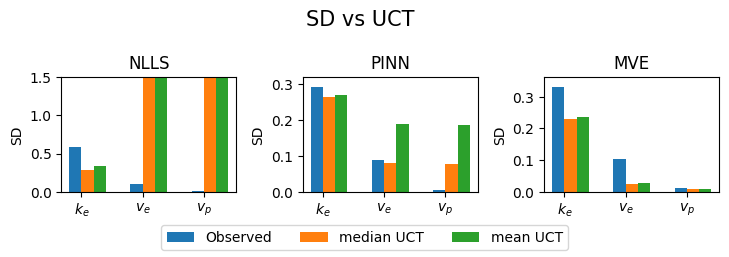

In [11]:
# plot the sd_parameter next to average uct per parameter
fig = plt.figure(figsize=(width_in_inches, width_in_inches/3))
gs = GridSpec(1, 3, figure=fig, width_ratios=[1,1,1])
for i, name in enumerate(sd_parameters_mask.keys()):
    ax = fig.add_subplot(gs[i])
    observed_sd = sd_parameters_mask[name]
    predicted_sd = mean_uct_in_mask[name]
    # grouped barplot for observed-predicted
    width = 0.2
    ax.bar(xt - width/2, observed_sd, width, label='Observed')
    ax.bar(xt + width/2, median_uct_in_mask[name], width, label='median UCT')
    ax.bar(xt+ 3*width/2, predicted_sd, width, label='mean UCT')
    ax.set_xticks(xt)
    ax.set_xticklabels(pk_param_names)
    ax.set_ylabel('SD')
    ax.set_title(name)
    # set ymax
    ax.set_ylim([0, min(1.5, max(max(observed_sd), max(predicted_sd)) * 1.1)])
    if i == len(sd_parameters_mask) - 1:
        handles, _ = ax.get_legend_handles_labels()

fig.legend(handles, ['Observed', 'median UCT', 'mean UCT'], loc='lower center', ncol=3)
plt.suptitle('SD vs UCT', fontsize=title_font_size)

plt.tight_layout(rect=[0, 0.08, 1, 1])

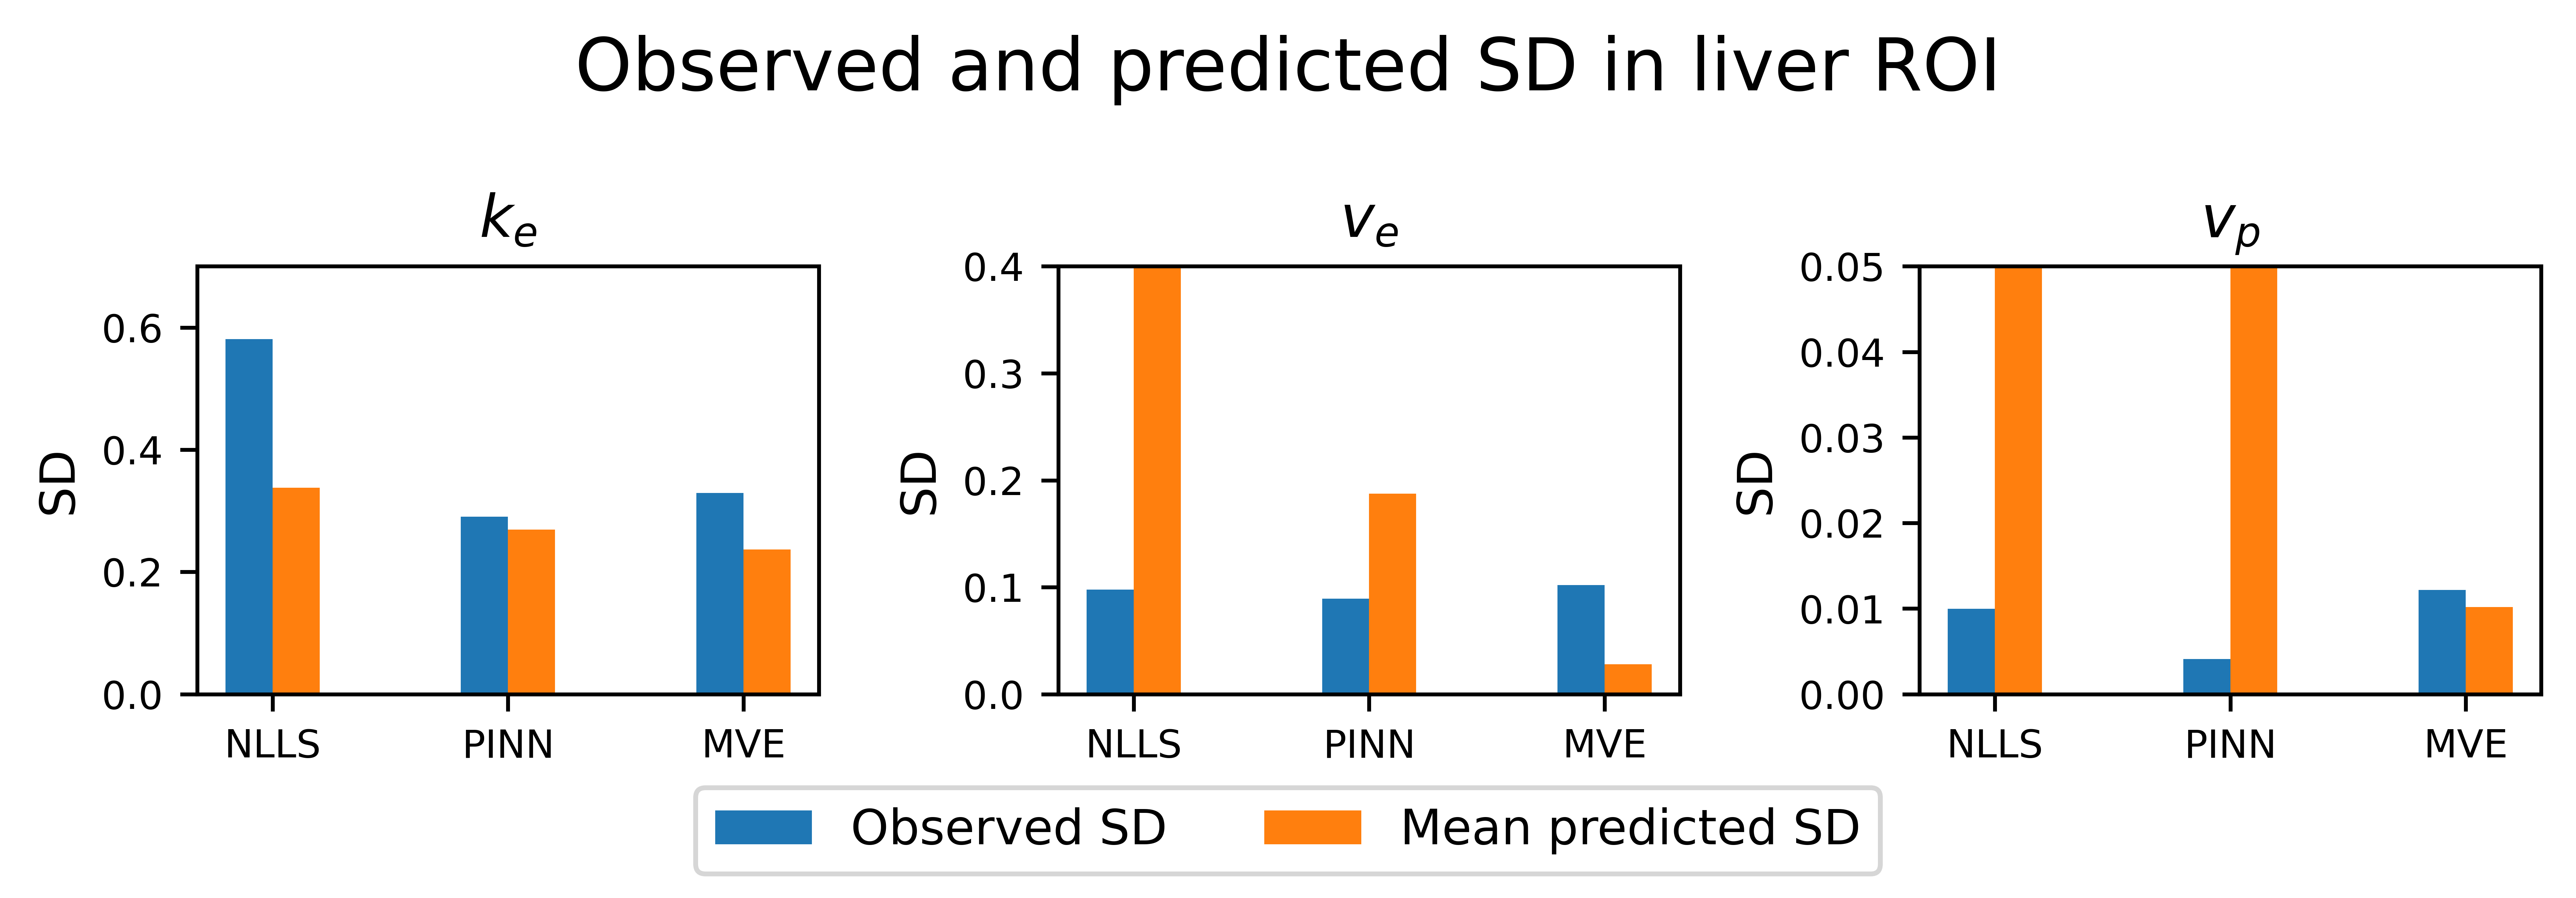

In [12]:
fig = plt.figure(figsize=(width_in_inches, width_in_inches / 3), dpi=1000)
gs = GridSpec(1, 3, figure=fig, width_ratios=[1, 1, 1])
maxes = [0.7, 0.4, 0.05]

for i, name in enumerate(pk_param_names):
    ax = fig.add_subplot(gs[i])
    observed_sd = [sd_parameters_mask[name][i] for name in sd_parameters_mask.keys()]
    predicted_uct = [mean_uct_in_mask[name][i] for name in uct_in_mask.keys()]

    # Boxplot for observed, median UCT, and mean UCT
    width=0.2
    ax.bar(xt-width/2, observed_sd, width, label='Observed')
    # box = ax.boxplot(predicted_uct, positions=xt+width/2, widths=width, showfliers=False, labels=pk_param_names, patch_artist=True, boxprops=dict(facecolor='lightblue'), medianprops=dict(color='red'))
    ax.bar(xt+width/2, predicted_uct, width, label='mean UCT')


    ax.set_ylabel('SD')
    ax.set_title(name)
    ax.set_ylim([0, maxes[i]])
    # ax.set_yscale('log')
    ax.set_xticks(xt)
    ax.set_xticklabels(sd_parameters_mask.keys())
    ax.tick_params(axis='both', labelsize=ticks_font_size)

handles = ax.get_legend_handles_labels()[0]
# handles.extend([box['boxes'][0]])
# handles.extend([plt.Line2D([0], [0], color='red', lw=2)])
fig.legend(handles, ['Observed SD', 'Mean predicted SD'], loc='lower center', ncol=3)
plt.suptitle(f'Observed and predicted SD in liver ROI', fontsize=title_font_size)
plt.tight_layout(rect=[0, 0.08, 1, 1])
